### In this notebook, we will use Quantum Approximate Optimization Algorithm (QAOA) to find the minimum vertex cover (MVC) of a graph. There are several approaches to solve this MVC problem, which will be explored in other notebooks

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import time
from datetime import datetime
import pickle
import random
from braket.circuits import Circuit

# magic line for producing visualizations in notebook
%matplotlib inline

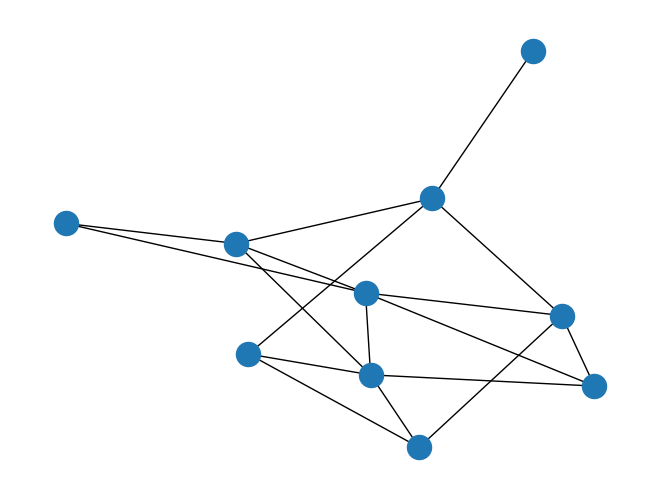

In [2]:
seed = 42
np.random.seed(seed)
random.seed(a=seed)
n = 10  # number of nodes/vertices
m = 0.3 # number of edges

# define graph object
G = nx.erdos_renyi_graph(n, m, seed=seed)
# positions for all nodes
pos = nx.spring_layout(G)

# choose random weights
# for (u, v) in G.edges():
#     G.edges[u,v]['weight'] = random.uniform(0, 1)

# draw graph
nx.draw(G, pos)
plt.savefig('random_graph_erdos.png', dpi=300)
plt.show()


In [147]:
# G = nx.petersen_graph()

In [8]:
Jfull = nx.to_numpy_array(G)

# get off-diagonal upper triangular matrix
J = np.triu(Jfull, k=1).astype(np.float64)

In [9]:
print(Jfull)

[[0. 0. 1. 1. 1. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
 [1. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 0. 1. 1. 1. 0.]]


In [10]:
Jfull = 0.5*Jfull
J = np.triu(Jfull, k = 1)
np.fill_diagonal(J, -1)
print(J)

[[-1.   0.   0.5  0.5  0.5  0.   0.   0.   0.5  0. ]
 [ 0.  -1.   0.5  0.5  0.   0.5  0.5  0.   0.   0.5]
 [ 0.   0.  -1.   0.   0.   0.5  0.   0.   0.   0.5]
 [ 0.   0.   0.  -1.   0.   0.   0.5  0.5  0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.5  0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1. ]]


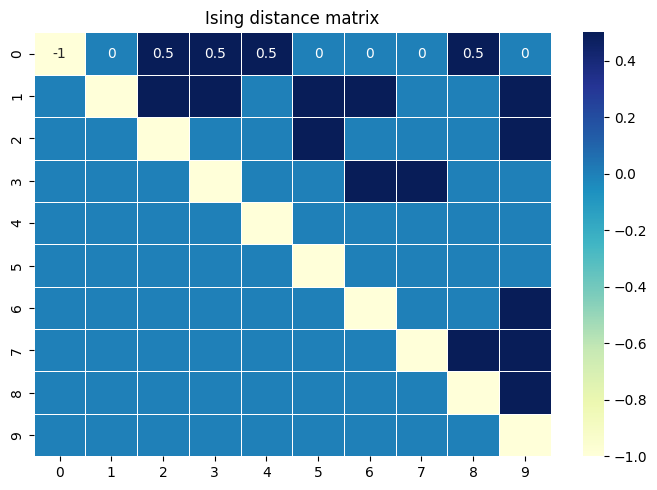

In [11]:
import seaborn as sns
plt.figure(1, figsize=[7, 5])
sns.heatmap(J, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout()

In [12]:
def driver(beta, n_qubits):
    """
    Returns circuit for driver Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()
    
    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2*beta)
        circ.add(gate)
    
    return circ

def cost_circuit(gamma, n_qubits, G):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    # get all non-zero entries (edges) from Ising matrix 

    for edge in G.edges:
        u, v = edge
        print(v)
        gate = Circuit().cnot(control=u, target=v)
        circ.add(gate)
        gate = Circuit().rz(v, 2 * gamma)
        circ.add(gate)
        gate = Circuit().cnot(control=u, target=v)
        circ.add(gate)
    for node in G.nodes:
        gate = Circuit().rz(node, 2 * gamma)
        circ.add(gate)
        
    # for qubit_pair in edges:
    #     # get interaction strength
    #     int_strength = ising[qubit_pair[0], qubit_pair[1]]
    #     # for Rigetti we decompose ZZ using CNOT gates
    #     if 'Aspen' in device.name:
    #         gate = ZZgate(qubit_pair[0], qubit_pair[1], gamma*int_strength)
    #         circ.add(gate)
    #     # classical simulators and IonQ support ZZ gate
    #     else:
    #         gate = Circuit().zz(qubit_pair[0], qubit_pair[1], angle=2*gamma*int_strength)
    #         circ.add(gate)

    return circ

In [13]:
# function to build the QAOA circuit with depth p
def circuit(params, n_qubits, G):
    """
    function to return full QAOA circuit
    """

    # initialize qaoa circuit with first Hadamard layer: for minimization start in |->
    circ = Circuit()
    # X_on_all = Circuit().x(range(0, n_qubits))
    # circ.add(X_on_all)
    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add circuit layers
    for mm in range(circuit_length):
        circ.add(cost_circuit(gammas[mm], n_qubits, G))
        circ.add(driver(betas[mm], n_qubits))

    return circ

In [14]:
from braket.circuits import FreeParameter

In [17]:
#create parameters
# gammas = [FreeParameter('gamma')]
# betas = [FreeParameter('beta')]
# params = gammas + betas

# # get circuit ansatz
# my_simple_circuit = circuit(params, n, G)

# # print test ansatz circuit
# print('Printing test circuit:')
# print(my_simple_circuit)

2
3
4
8
2
3
5
6
9
5
9
6
7
9
8
9
9
Printing test circuit:
T  : │  0  │  1  │       2       │  3  │     4     │       5       │     6     │     7     │       8       │     9     │            10             │      11       │    12     │         13          │      14       │    15     │            16             │      17       │    18     │         19          │      20       │    21     │         22          │      23       │    24     │      25       │      26       │ 27  │      28       │      29       │ 30  │      31       │      32      │
      ┌───┐                                                                                                                                                                     ┌─────────────┐       ┌────────────┐                                                                                                                                                                                                                                                 

In [18]:
def objective_function(params, qaoa_circuit, ising, G, device, n_shots, tracker, verbose):
    """
    objective function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    if verbose:
        print("==================================" * 2)
        print("Calling the quantum circuit. Cycle:", tracker["count"])

    # create parameter dict
    params_dict = {str(fp): p for fp, p in zip(qaoa_circuit.parameters, params)}
    
    # classically simulate the circuit
    # set the parameter values using the inputs argument
    # execute the correct device.run call depending on whether the backend is local or cloud based
    if isinstance(device, LocalSimulator):
        task = device.run(qaoa_circuit, shots=n_shots, inputs=params_dict)
    else:
        task = device.run(
            qaoa_circuit, shots=n_shots, inputs=params_dict, poll_timeout_seconds=3 * 24 * 60 * 60
        )

    # get result for this task
    result = task.result()

    # convert results (0 and 1) to ising (-1 and 1)
    meas_ising = result.measurements
    meas_ising[meas_ising == 0] = -1

    # get all energies (for every shot): (n_shots, 1) vector
    all_energies = np.diag(np.dot(meas_ising, np.dot(ising, np.transpose(meas_ising))))

    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    tracker["opt_energies"].append(energy_min)
    optimal_string = -meas_ising[np.argmin(all_energies)]
    tracker["opt_bitstrings"].append(optimal_string)

    # store optimal (classical) result/bitstring
    if energy_min < tracker["optimal_energy"]:
        tracker.update({"optimal_energy": energy_min})
        tracker.update({"optimal_bitstring": optimal_string})

    # store global minimum
    tracker["global_energies"].append(tracker["optimal_energy"])

    # energy expectation value
    energy_expect = np.sum(all_energies) / n_shots

    if verbose:
        print("Minimal energy:", energy_min)
        print("Optimal classical string:", optimal_string)
        print("Energy expectation value (cost):", energy_expect)

    # update tracker
    tracker.update({"count": tracker["count"] + 1, "res": result})
    tracker["costs"].append(energy_expect)
    tracker["params"].append(params)

    return energy_expect

In [19]:
def train(
    device, options, p, ising, G, n_qubits, n_shots, opt_method, tracker, verbose
):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print("Starting the training.")

    print("==================================" * 2)
    print(f"OPTIMIZATION for circuit depth p={p}")

    if not verbose:
        print('Param "verbose" set to False. Will not print intermediate steps.')
        print("==================================" * 2)

    # initialize
    cost_energy = []

    # randomly initialize variational parameters within appropriate bounds
    gamma_initial = np.random.uniform(0, 2 * np.pi, p).tolist()
    beta_initial = np.random.uniform(0, np.pi, p).tolist()
    params0 = np.array(gamma_initial + beta_initial)

    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    tracker["params"].append(params0)
    
    gamma_params = [FreeParameter(f"gamma_{i}") for i in range(p)]
    beta_params = [FreeParameter(f"beta_{i}") for i in range(p)]
    params = gamma_params + beta_params
    qaoa_circ = circuit(params, n, G)

    # run classical optimization (example: method='Nelder-Mead')
    result = minimize(
        objective_function,
        params0,
        args=(qaoa_circ, ising, G, device, n_shots, tracker, verbose),
        options=options,
        method=opt_method,
    )

    # store result of classical optimization
    result_energy = result.fun
    cost_energy.append(result_energy)
    print("Final average energy (cost):", result_energy)
    result_angle = result.x
    print("Final angles:", result_angle)
    print("Training complete.")

    return result_energy, result_angle, tracker

In [20]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 3  # circuit depth for QAOA
SHOTS = 3000  # number measurements to make on circuit
OPT_METHOD = 'COBYLA'  # SLSQP, COBYLA, Nelder-Mead, BFGS, Powell, ...

# set up the problem
# n_qubits = J.shape[0]

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n])
energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))

# set tracker to keep track of results
tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_bitstrings': [],                 # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': []                          # Track parameters
}
                      

# set options for classical optimization
options = {'disp': True, 'maxiter': 50}

In [21]:
from braket.devices import LocalSimulator
device = LocalSimulator()
# from braket.aws import AwsDevice
# from braket.devices import Devices
# device = AwsDevice(Devices.IQM.Garnet)

##################################################################################
# run QAOA optimization on graph 
##################################################################################

print('Circuit depth hyperparameter:', DEPTH)
print('Problem size:', n)

# kick off training
start = time.time()
result_energy, result_angle, tracker = train(
    device = device, options=options, p=DEPTH, ising=J, G=G, n_qubits=n, n_shots=SHOTS, 
    opt_method=OPT_METHOD, tracker=tracker, verbose=True)
end = time.time()

# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energy:', tracker['optimal_energy'])
print('Optimal classical bitstring:', tracker['optimal_bitstring'])

Circuit depth hyperparameter: 3
Problem size: 10
Starting the training.
OPTIMIZATION for circuit depth p=3
2
3
4
8
2
3
5
6
9
5
9
6
7
9
8
9
9
2
3
4
8
2
3
5
6
9
5
9
6
7
9
8
9
9
2
3
4
8
2
3
5
6
9
5
9
6
7
9
8
9
9
Calling the quantum circuit. Cycle: 1
Minimal energy: -14.5
Optimal classical string: [-1 -1  1  1  1  1  1 -1  1 -1]
Energy expectation value (cost): -8.467
Calling the quantum circuit. Cycle: 2
Minimal energy: -14.5
Optimal classical string: [ 1 -1 -1  1 -1  1 -1 -1 -1  1]
Energy expectation value (cost): -8.311666666666667
Calling the quantum circuit. Cycle: 3
Minimal energy: -14.5
Optimal classical string: [-1 -1 -1  1  1  1 -1 -1  1  1]
Energy expectation value (cost): -10.189
Calling the quantum circuit. Cycle: 4
Minimal energy: -14.5
Optimal classical string: [-1  1  1 -1  1 -1  1  1  1 -1]
Energy expectation value (cost): -9.836
Calling the quantum circuit. Cycle: 5
Minimal energy: -14.5
Optimal classical string: [-1 -1  1  1  1 -1  1 -1  1 -1]
Energy expectation value (co

Minimal energy: -14.5
Optimal classical string: [ 1 -1 -1  1 -1  1 -1 -1 -1  1]
Energy expectation value (cost): -11.580666666666668
Calling the quantum circuit. Cycle: 36
Minimal energy: -14.5
Optimal classical string: [ 1 -1 -1  1 -1  1 -1 -1 -1  1]
Energy expectation value (cost): -11.76
Calling the quantum circuit. Cycle: 37
Minimal energy: -14.5
Optimal classical string: [ 1  1 -1 -1 -1 -1  1  1 -1 -1]
Energy expectation value (cost): -11.752666666666666
Calling the quantum circuit. Cycle: 38
Minimal energy: -14.5
Optimal classical string: [ 1  1 -1 -1 -1 -1 -1  1 -1  1]
Energy expectation value (cost): -11.913333333333334
Calling the quantum circuit. Cycle: 39
Minimal energy: -14.5
Optimal classical string: [-1 -1  1  1  1  1 -1 -1  1  1]
Energy expectation value (cost): -11.978
Calling the quantum circuit. Cycle: 40
Minimal energy: -14.5
Optimal classical string: [ 1 -1 -1  1 -1  1 -1 -1 -1  1]
Energy expectation value (cost): -12.011666666666667
Calling the quantum circuit. Cyc

In [10]:
# optimal_bit_string_list=[]
# optimal_energy_list=[]
# execution_time=[]
# for runs in range(0,100):
#     start = time.time()
#     result_energy, result_angle, tracker = train(
#     device = device, options=options, p=DEPTH, ising=J, G=G, n_qubits=n, n_shots=SHOTS, 
#     opt_method=OPT_METHOD, tracker=tracker, verbose=True)
#     end = time.time()

#     # print execution time
#     print('Code execution time [sec]:', end - start)
#     execution_time.append(end - start)
#     # print optimized results
#     print('Optimal energy:', tracker['optimal_energy'])
#     print('Optimal classical bitstring:', tracker['optimal_bitstring'])
#     optimal_bit_string_list.append(tracker['optimal_bitstring'])
#     optimal_energy_list.append(tracker['optimal_energy'])
    

In [12]:
# print(optimal_energy_list)

In [13]:
# for i in optimal_bit_string_list:
#     print(np.sum(np.array(i)))

---------------------------------------------
running for 5 nodes
---------------------------------------------



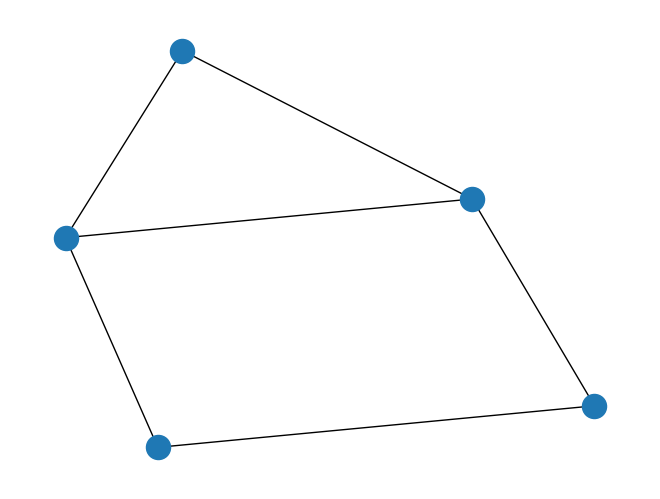

[[-1.   0.5  0.5  0.5  0. ]
 [ 0.  -1.   0.   0.5  0.5]
 [ 0.   0.  -1.   0.   0.5]
 [ 0.   0.   0.  -1.   0. ]
 [ 0.   0.   0.   0.  -1. ]]
Circuit depth hyperparameter: 3
Problem size: 5
---------------------------------------------
running for 10 nodes
---------------------------------------------



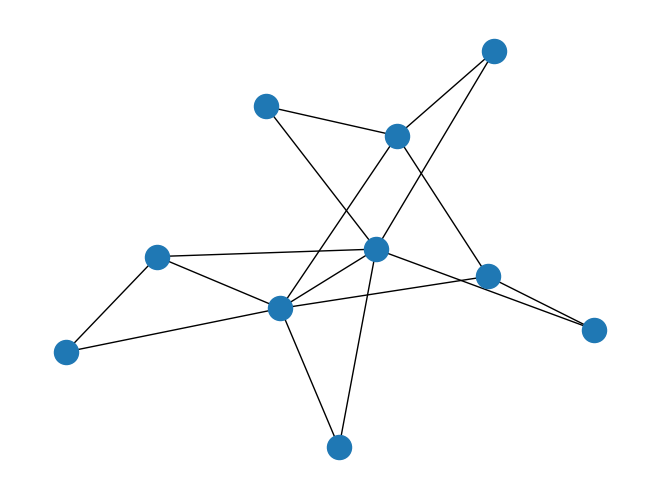

[[-1.   0.5  0.5  0.5  0.   0.5  0.   0.5  0.   0.5]
 [ 0.  -1.   0.   0.5  0.5  0.   0.5  0.5  0.5  0. ]
 [ 0.   0.  -1.   0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.  -1.   0.5  0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1. ]]
Circuit depth hyperparameter: 3
Problem size: 10
---------------------------------------------
running for 15 nodes
---------------------------------------------



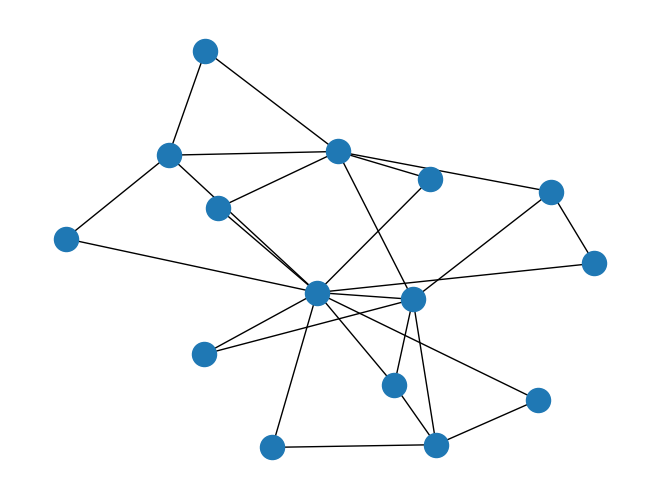

[[-1.   0.5  0.5  0.5  0.   0.5  0.   0.5  0.   0.5  0.5  0.5  0.   0.5
   0.5]
 [ 0.  -1.   0.   0.5  0.5  0.   0.5  0.5  0.5  0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.  -1.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.  -1.   0.5  0.5  0.   0.   0.   0.   0.   0.5  0.5
   0. ]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.5  0.5  0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.5  0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.5  0.   0.   0.
   0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.
   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.

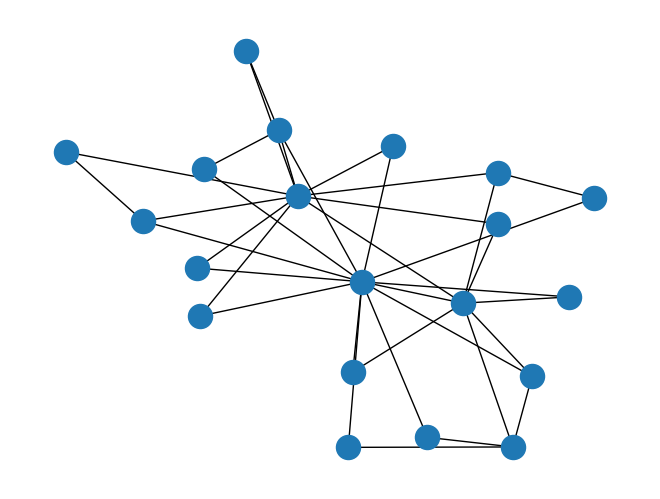

[[-1.   0.5  0.5  0.5  0.   0.5  0.   0.5  0.   0.5  0.5  0.5  0.   0.5
   0.5  0.   0.   0.5  0.5  0.5]
 [ 0.  -1.   0.   0.5  0.5  0.   0.5  0.5  0.5  0.   0.   0.   0.   0.
   0.   0.5  0.   0.5  0.   0. ]
 [ 0.   0.  -1.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.5  0.   0.   0. ]
 [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.5  0.5  0.   0.   0.   0.   0.   0.5  0.5
   0.   0.5  0.5  0.   0.5  0.5]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.5  0.5  0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.5  0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.5  0.   0.   0.
   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.  

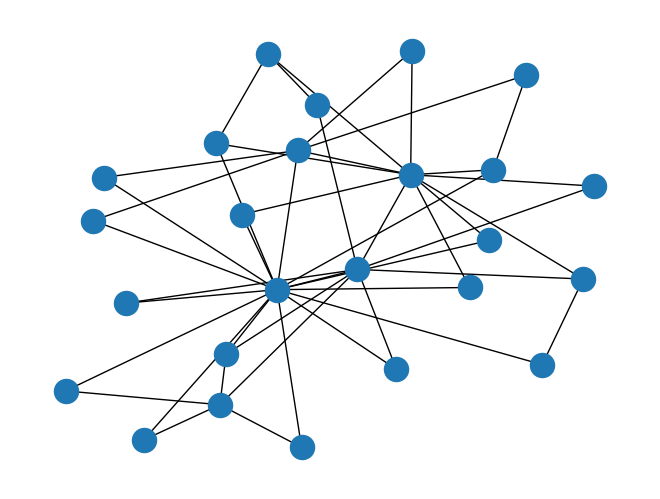

[[-1.   0.5  0.5  0.5  0.   0.5  0.   0.5  0.   0.5  0.5  0.5  0.   0.5
   0.5  0.   0.   0.5  0.5  0.5  0.5  0.   0.5  0.5  0. ]
 [ 0.  -1.   0.   0.5  0.5  0.   0.5  0.5  0.5  0.   0.   0.   0.   0.
   0.   0.5  0.   0.5  0.   0.   0.   0.5  0.   0.   0. ]
 [ 0.   0.  -1.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   0.5  0.5  0.   0.   0.   0.   0.   0.5  0.5
   0.   0.5  0.5  0.   0.5  0.5  0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.5  0.5  0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.5]
 [ 0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.5  0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0

In [28]:
optimal_bit_string_list=[]
optimal_energy_list=[]
execution_time=[]

for i in range(5,26,5):
    print('---------------------------------------------')
    print(f'running for {i} nodes')
    print('---------------------------------------------')
    print('')
    seed = 42
    np.random.seed(seed)
    random.seed(a=seed)
    n = i  # number of nodes/vertices
    p = 2  # number of edges
    
    # define graph object
    G = nx.barabasi_albert_graph(n,p)
    # G = nx.erdos_renyi_graph(n, p, seed=seed)
    # positions for all nodes
    pos = nx.spring_layout(G)
    
    # choose random weights
    # for (u, v) in G.edges():
    #     G.edges[u,v]['weight'] = random.uniform(0, 1)
    
    # draw graph
    nx.draw(G, pos)
    plt.savefig(f'random_graph_{i}.png', dpi=300)
    plt.show()

    Jfull = nx.to_numpy_array(G)
    Jfull = 0.5*Jfull
    J = np.triu(Jfull, k = 1)
    np.fill_diagonal(J, -1)
    print(J)

    DEPTH = 3  # circuit depth for QAOA
    SHOTS = 3000  # number measurements to make on circuit
    OPT_METHOD = 'Nelder-Mead'  # SLSQP, COBYLA, Nelder-Mead, BFGS, Powell, ...
    
    # set up the problem
    # n_qubits = J.shape[0]
    
    # initialize reference solution (simple guess)
    bitstring_init = -1 * np.ones([n])
    energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))
    
    # set tracker to keep track of results
    tracker = {
        'count': 1,                           # Elapsed optimization steps
        'optimal_energy': energy_init,        # Global optimal energy
        'opt_energies': [],                   # Optimal energy at each step
        'global_energies': [],                # Global optimal energy at each step
        'optimal_bitstring': bitstring_init,  # Global optimal bitstring
        'opt_bitstrings': [],                 # Optimal bitstring at each step
        'costs': [],                          # Cost (average energy) at each step
        'res': None,                          # Quantum result object
        'params': []                          # Track parameters
    }
                          
    
    # set options for classical optimization
    options = {'disp': True, 'maxiter': 100}

    from braket.devices import LocalSimulator
    device = LocalSimulator()
    # from braket.aws import AwsDevice
    # from braket.devices import Devices
    # device = AwsDevice(Devices.IQM.Garnet)
    
    ##################################################################################
    # run QAOA optimization on graph 
    ##################################################################################
    
    print('Circuit depth hyperparameter:', DEPTH)
    print('Problem size:', n)
    
    # kick off training
    # start = time.time()
    # result_energy, result_angle, tracker = train(
    #     device = device, options=options, p=DEPTH, ising=J, G=G, n_qubits=n, n_shots=SHOTS, 
    #     opt_method=OPT_METHOD, tracker=tracker, verbose=True)
    # end = time.time()
    
    # # print execution time
    # exec_time = end - start
    # print('Code execution time [sec]:', end - start)
    
    # # print optimized results
    # print('Optimal energy:', tracker['optimal_energy'])
    # print('Optimal classical bitstring:', tracker['optimal_bitstring'])

    # execution_time.append(exec_time)
    # optimal_bit_string_list.append(tracker['optimal_bitstring'])
    # optimal_energy_list.append(tracker['optimal_energy'])

In [19]:
print(optimal_bit_string_list)

[array([-1,  1,  1, -1,  1]), array([-1,  1,  1, -1,  1, -1,  1,  1,  1, -1]), array([ 1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1])]
